In [1]:
# Import necessary libraries
import gempy as gp
import gempy_viewer as gpv
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import pandas as pd
import os
import verde as vd
from gempy_engine.core.data.centered_grid import CenteredGrid
import gemgis as gg
import pyvista as pv
from disba import PhaseDispersion,EigenFunction,PhaseSensitivity

import time, array, random

from deap import base, creator, tools, algorithms
from scipy.interpolate import interp1d
import vtk

Setting Backend To: AvailableBackends.numpy


# Functions 

## Modelling 


$V_p = \left( \frac{\rho}{0.23} \right)^4 . 0.3048$


In [2]:
# Function to estimate the P and S velocities and Poisson ration in function of initial density
def calculate_parameters(densities):
    '''
    Vp = ((Density\0.23)**4)*0.3048
    Vs = Vp/sqrt(3)
    '''
    
    vp = ((densities/310)**4)*0.3048 #gardner
    vs = vp / np.sqrt(3)
    
    return vp,vs


# Function to estimate the P velocities and Densities in function of initial density
def calculate_parameters_from_vs(vel_s):
    '''
    Vp = ((Density\0.23)**4)*0.3048
    Vs = Vp/sqrt(3)
    '''
    
    vp = vel_s * np.sqrt(3)

    densities = 310*((vp/0.3048)**(1/4))

    return vp,densities
    

# Function to generate a complete seismic model with random variation at each point
def create_complete_seismic_model(xi,yj,num_layers):
    '''
    xi: numpy.ndarray region [west-east points]) with a specific spacing (100 units in this case).
    yj: numpy.ndarray region [south-north points]) with a specific spacing (100 units in this case).
    num_layers: Number of layers of the model 
    '''
    
    # Initialize lists to store the variations of each parameter for each receiver
    x_l = []
    y_l = []
    depths = []
    vp = []
    vs = []
    densities = []
    formation = []
    
    # Define variation ranges for each layer
    depth_ranges = [(-0.4, -0.5), (-0.9, -1.0), (-1.4, -1.5)]
    density_ranges = [(1600, 1700),(1000, 1200), (1300, 1400)]
    
    for l in range(num_layers):
        x_l.append(xi)
        y_l.append(yj)
        
        # Generate random variations for each layer
        depths.append(np.random.uniform(*depth_ranges[l], size=xi.shape))
        densi = np.random.uniform(*density_ranges[l], size=yj.shape)
        densities.append(densi)
            
        # Calculate the parameters individually for each point
        vp.append(calculate_parameters(densi)[0])
        vs.append(calculate_parameters(densi)[1])

        formation.append('soil'+str(l+1))

    # Salvar modelo e dados
    model = {
        'xi':x_l,
        'yj':y_l,
        'vp': vp,
        'vs': vs,
        'depths': depths,
        'densities': densities,
        'num_layers': num_layers,
        'formation': formation,
    }

    return model

## Dispersion curve estimation

In [76]:
def create_velocity_model_from_profile(model_profile):

    dens_values_unique,dens_index_unique = np.unique(model_profile,return_index=True)

    dens_index_unique = sorted(dens_index_unique)

    depth_ = np.linspace(0,-2.,len(model_profile)+1)

    thickness_ = [depth_[i] for i in dens_index_unique]
    thickness_.append(-2.0)

    thickness = np.diff(thickness_)*(-1)

    dens = model_profile[dens_index_unique]

    vp, vs = calculate_parameters(dens)

    vmodel = []
    for idx in range(len(dens)):

        # thickness, Vp, Vs, density
        # km, km/s, km/s, g/cm3        

        vmodel.append([thickness[idx]/1000,vp[idx]/1000,vs[idx]/1000,dens[idx]/1000])
   
    velocity_model = np.array(vmodel)    

    return velocity_model

def create_velocity_model_from_profile_vs(model_profile):
    
    vmodel = []
    for (thickness,vs) in zip(*model_profile):
 
        vp, dens = calculate_parameters_from_vs(vs)
        
        # thickness, Vp, Vs, density
        # km, km/s, km/s, g/cm3

        vmodel.append([thickness,vp/1000,vs/1000,dens/1000])
   
    velocity_model = np.array(vmodel)    

    return velocity_model

def estimate_disp_from_velocity_model(vel_mol,number_samples=100):
    # Periods must be sorted starting with low periods
    hz = np.linspace(1, 100.0, number_samples) # Hertz
    
    t = 1/hz[::-1] # Hertz to seconds
    
    # Fundamental mode corresponds to mode 0
    pdisp = PhaseDispersion(*vel_mol.T,dc=0.0001)

    cpr = pdisp(t, mode=0, wave="rayleigh")

    return cpr    

# Code

In [4]:
data_path = 'data/'

In [5]:
glob.glob(data_path+'/*')

['data/points.csv',
 'data/orientations.csv',
 'data/density_block.vtk',
 'data/density_block.npy']

In [6]:
spacing = 25

west, east, south, north = 0, 100, 0, 100
region = (west, east, south, north)

# create the grid coordinates
X,Y = vd.grid_coordinates(region=region, spacing=spacing)

In [7]:

# Função principal
num_layers = 3
model = create_complete_seismic_model(xi=X,yj=Y,num_layers=num_layers)

Text(0, 0.5, 'Northing')

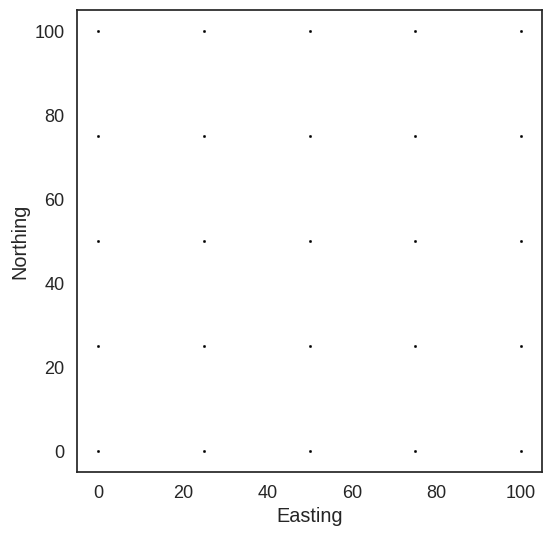

In [8]:
plt.figure(figsize=(6, 6))
ax = plt.subplot(111)
ax.scatter(X,Y,s=10,c='k',marker='.')

plt.xlabel("Easting")
plt.ylabel("Northing")

In [9]:
lst_soils = []
for l in range(num_layers):
    for k in range(len(model['xi'][l].ravel())):
            lst_soils.append({'X':model['xi'][l].ravel()[k], 'Y':model['yj'][l].ravel()[k], 'Z':model['depths'][l].ravel()[k], 'formation':model['formation'][l]})

In [10]:
soils_df = pd.DataFrame.from_dict(data=lst_soils)

In [11]:
soils_df

,X,Y,Z,formation
0,0.00,0.00,-0.48,soil1
1,25.00,0.00,-0.45,soil1
2,50.00,0.00,-0.50,soil1
3,75.00,0.00,-0.41,soil1
4,100.00,0.00,-0.47,soil1
...,...,...,...,...
70,0.00,100.00,-1.43,soil3
71,25.00,100.00,-1.47,soil3
72,50.00,100.00,-1.48,soil3
73,75.00,100.00,-1.45,soil3


In [12]:
os.remove('data/points.csv')
soils_df.to_csv('data/points.csv', header=soils_df.columns, index=None, sep=',', mode='a')

In [13]:
lst_soils_orient = []
for l in range(num_layers):
    for tim in range(4):
        lst_soils_orient.append({'X':np.random.choice(model['xi'][l].ravel())*0.75, 'Y':np.random.choice(model['yj'][l].ravel())*0.75, 'Z':np.random.choice(model['depths'][l].ravel())*0.9, 'formation':model['formation'][l],'Azimuth':0,'Dip':0,'Polarity':1})
soils_orient_df = pd.DataFrame.from_dict(data=lst_soils_orient)

In [14]:
soils_orient_df

,X,Y,Z,formation,Azimuth,Dip,Polarity
0,56.25,18.75,-0.45,soil1,0,0,1
1,56.25,0.00,-0.45,soil1,0,0,1
2,0.00,56.25,-0.45,soil1,0,0,1
3,37.50,75.00,-0.42,soil1,0,0,1
4,0.00,18.75,-0.85,soil2,0,0,1
5,37.50,75.00,-0.88,soil2,0,0,1
6,18.75,75.00,-0.83,soil2,0,0,1
7,0.00,37.50,-0.89,soil2,0,0,1
8,0.00,37.50,-1.33,soil3,0,0,1
9,37.50,18.75,-1.28,soil3,0,0,1


In [15]:
os.remove('data/orientations.csv')
soils_orient_df.to_csv('data/orientations.csv', header=soils_orient_df.columns, index=None, sep=',', mode='a')


In [16]:
density_grid = np.concatenate(model['densities'])

depth_grid = np.concatenate(model['depths'])

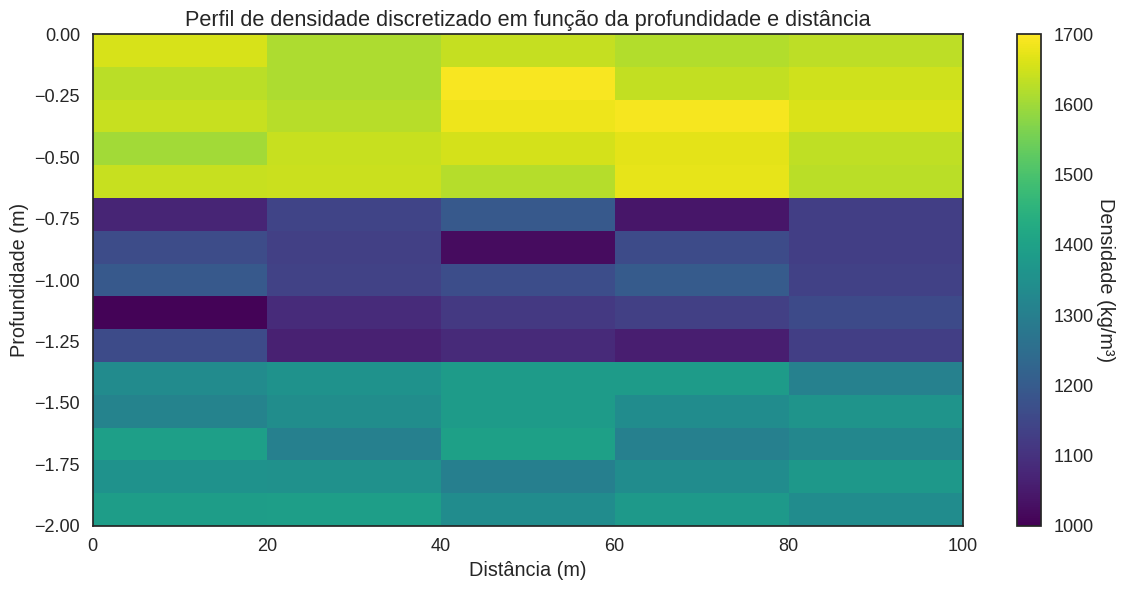

In [17]:
# Plotar o perfil de densidade ajustado
fig, ax = plt.subplots(figsize=(12, 6))
cmap = plt.get_cmap("viridis")
norm = mcolors.Normalize(vmin=1000, vmax=1700)
extent = [0, 100, -2, 0]
cax = ax.imshow(density_grid, extent=extent, origin='upper', cmap=cmap, aspect='auto', norm=norm)

# Adicionar barra de cores
cbar = fig.colorbar(cax)
cbar.set_label('Densidade (kg/m³)', rotation=270, labelpad=15)

# Configurações do gráfico
ax.set_xlabel('Distância (m)')
ax.set_ylabel('Profundidade (m)')
ax.set_title('Perfil de densidade discretizado em função da profundidade e distância')

# Ajustar layout e salvar o gráfico
plt.tight_layout()
plt.savefig('perfil_densidade_discretizado.png', dpi=300)
plt.show()

In [18]:
# Create a GeoModel instance

grid_reso = 50
# Dados do modelo
extent = [0, 100, 0, 100, -2,0]  # [x_min, x_max, y_min, y_max, z_min, z_max]
resolution = [grid_reso,grid_reso,int(grid_reso/2)]  # Resolução do grid


data = gp.create_geomodel(
    project_name='soil_horizontal',
    extent=extent,
    resolution=resolution,
    importer_helper=gp.data.ImporterHelper(
        path_to_orientations=data_path + "/orientations.csv",
        path_to_surface_points=data_path + "/points.csv"
    )
)


In [19]:
# Compute the geological mode
gp.compute_model(data)
geo_data = data

Setting Backend To: AvailableBackends.numpy
Chunking done: 14 chunks


In [20]:
# Define structural groups and age/stratigraphic relationship
gp.map_stack_to_surfaces(
    gempy_model=geo_data,
    mapping_object={
        "Strat_Series1": tuple(soils_orient_df.formation.unique().tolist())
    }
)

StructuralFrame(
	structural_groups=[
StructuralGroup(
	name=Strat_Series1,
	structural_relation=StackRelationType.ERODE,
	elements=[
Element(
	name=soil1,
	color=#015482,
	is_active=True
),
Element(
	name=soil2,
	color=#9f0052,
	is_active=True
),
Element(
	name=soil3,
	color=#ffbe00,
	is_active=True
)
]
)
],
	fault_relations=
[[False]],

In [21]:
gp.compute_model(geo_data)

Setting Backend To: AvailableBackends.numpy
Chunking done: 14 chunks


Solutions(4 Octree Levels, 3 DualContouringMeshes)

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


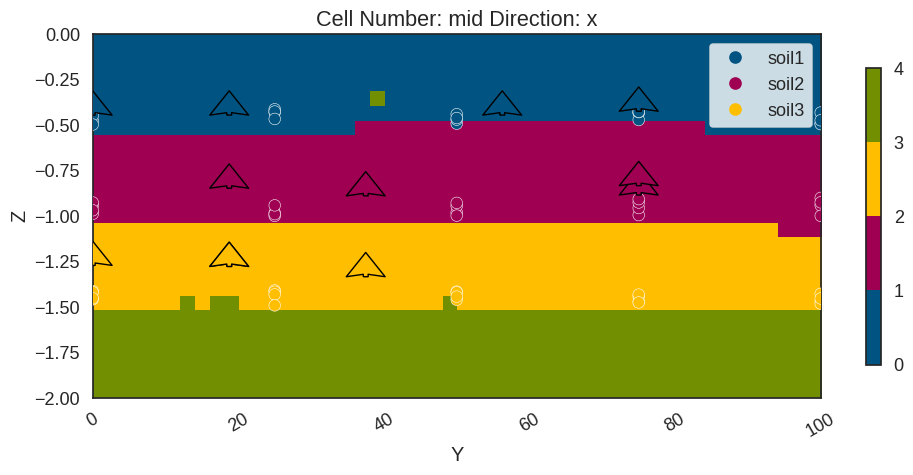

In [22]:
# Plot the result of the model in the x and y direction with data and without boundaries
gpv.plot_2d(geo_data, direction=['x'],ve=25, show_data=True, show_boundaries=True)

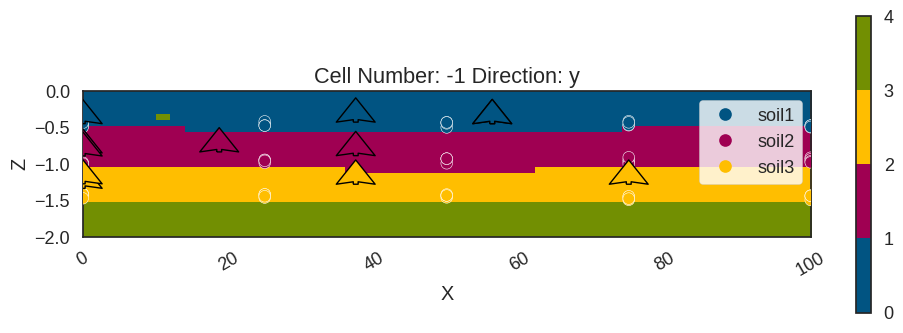

In [23]:
gpv.plot_2d(geo_data, cell_number=[-1], direction=['y'],ve=10, show=True,kwargs_regular_grid={'alpha': .5})

In [24]:
gempy_plot = gpv.plot_3d(
    model=geo_data,
    show_scalar=False,
    ve=10,
    show=False,
    image=False,
    transformed_data=False,
    kwargs_pyvista_bounds={
            'show_xlabels': False,
            'show_ylabels': False,
            'show_zlabels': True,
            'show_xaxis': False,
            'show_yaxis': False,
    },
    kwargs_plot_data={
            'arrow_size': 40.0
    }
)



gempy_plot.p.show()

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/gempy_viewer/API/_plot_2d_API.py:174: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  p.fig.show()


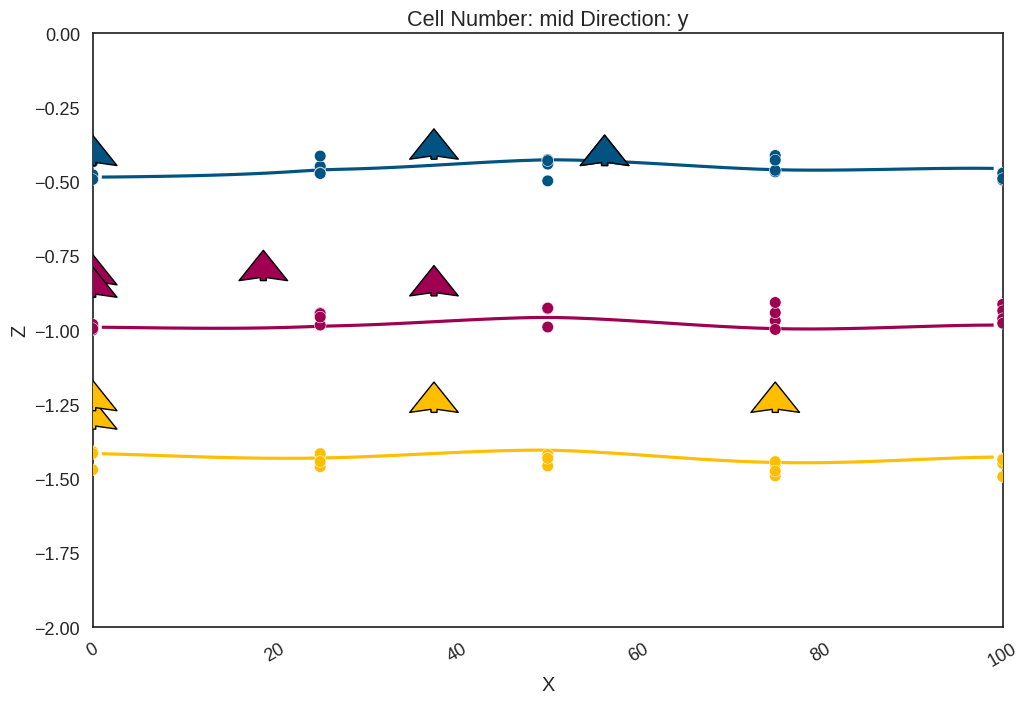

In [25]:
gpv.plot_2d(geo_data, show_value=False, show_lith=False, show_scalar=False,legend=False, cell_number='mid')

In [35]:
lith_block = geo_data.solutions.raw_arrays.lith_block.reshape(grid_reso,grid_reso,int(grid_reso/2))
lith_block.shape

(50, 50, 25)

In [36]:
density_values,density_index = np.unique(geo_data.solutions.raw_arrays.lith_block,return_index=True)

In [37]:
density_values[np.argsort(density_index)]

array([4, 3, 2, 1, 5], dtype=int8)

In [38]:
density_values = [np.mean(i) for i in model['densities']]
density_values.append(2000)

In [39]:
density_dict = {k: v for k,v in zip(np.unique(np.round(lith_block)), density_values)}
density_dict

{1: 1643.6203887579363, 2: 1120.8561641847805, 3: 1352.422884198673, 4: 2000}

In [40]:
density_block = gg.utils.assign_properties(lith_block=lith_block, property_dict=density_dict)

In [41]:
np.save('data/density_block.npy', density_block)

In [42]:
volume = pv.wrap(density_block)

In [43]:
volume.save('data/density_block.vtk',binary=True)

# DISBA - surface wave dispersion

In [44]:
density_block.shape

(50, 50, 25)

In [45]:
north/grid_reso

2.0

In [46]:
lst_receptor = np.arange(1, density_block.shape[0]-1,10)

In [47]:
lst_receptor

array([ 1, 11, 21, 31, 41])

In [56]:
line_row = np.random.randint(low=0,high=density_block.shape[0]-1)
line_row

14

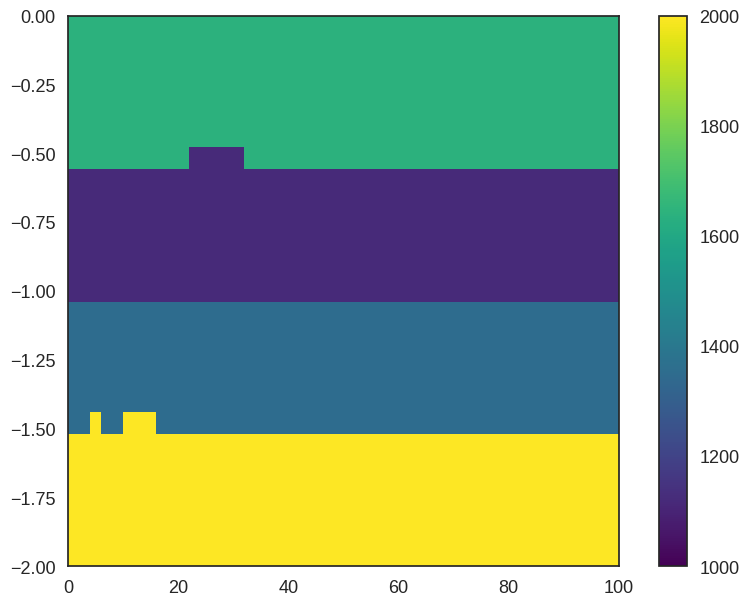

In [57]:
im = plt.imshow(density_block[line_row,:,:].T, cmap='viridis',extent=[0, 100, -2.0, 0],vmin=1000.0,vmax=2000.0,aspect=50,origin='lower')

plt.colorbar(im);

In [58]:
slice_block = density_block[line_row,:,:].T

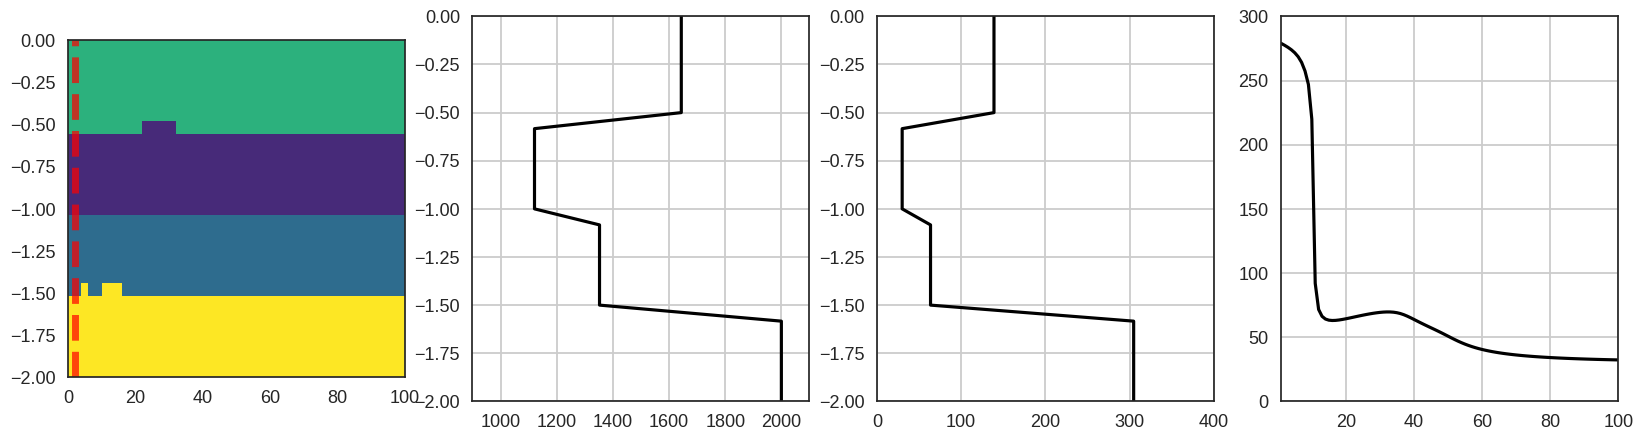

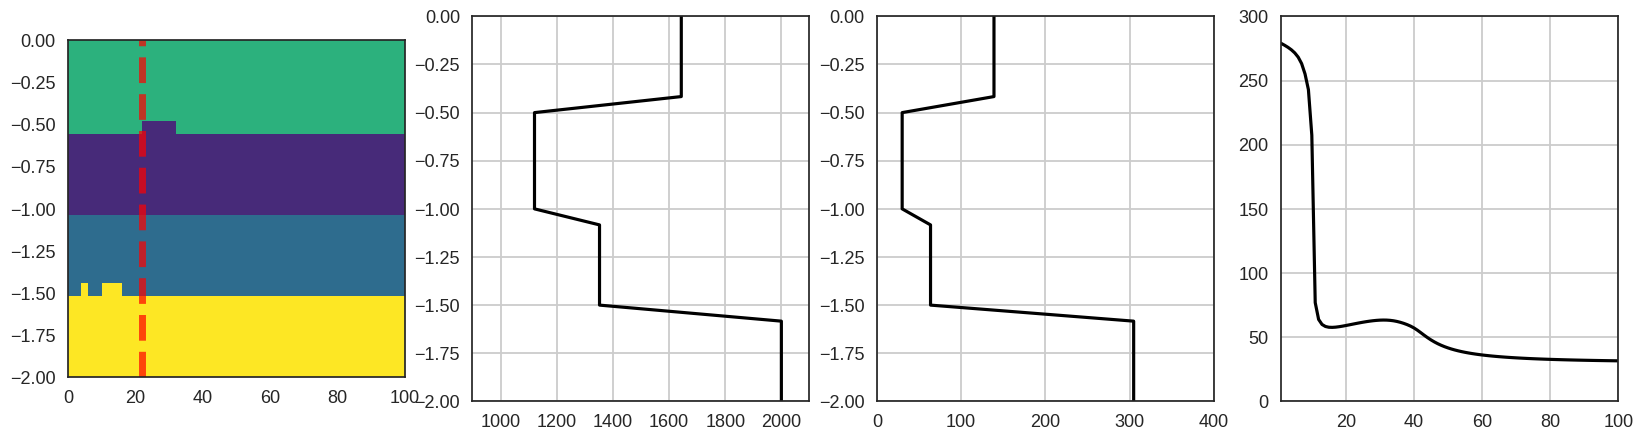

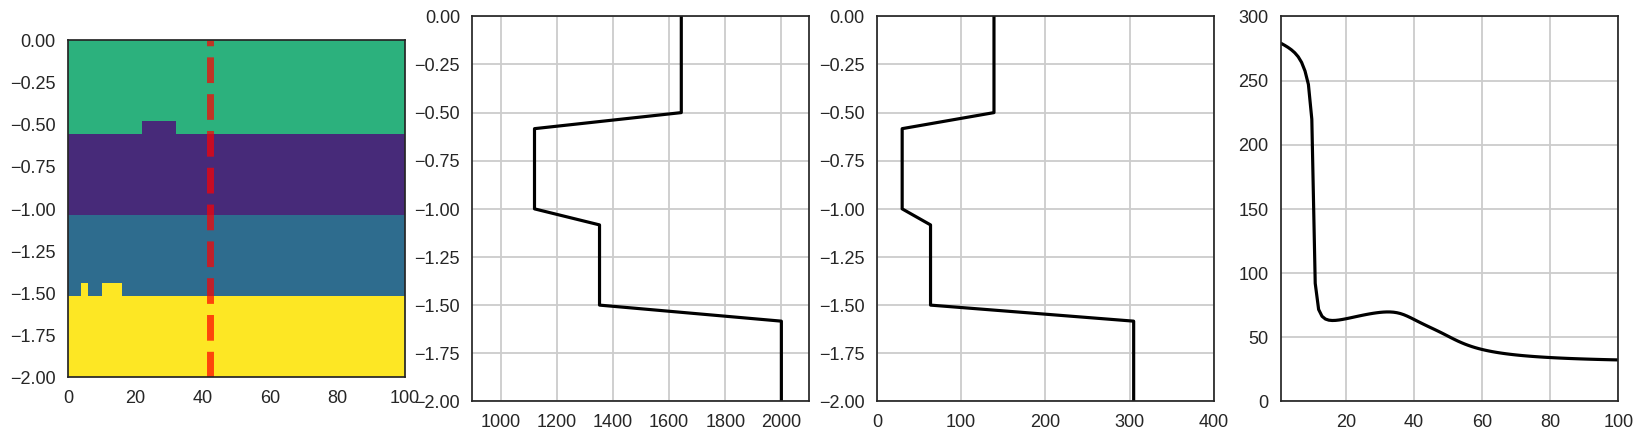

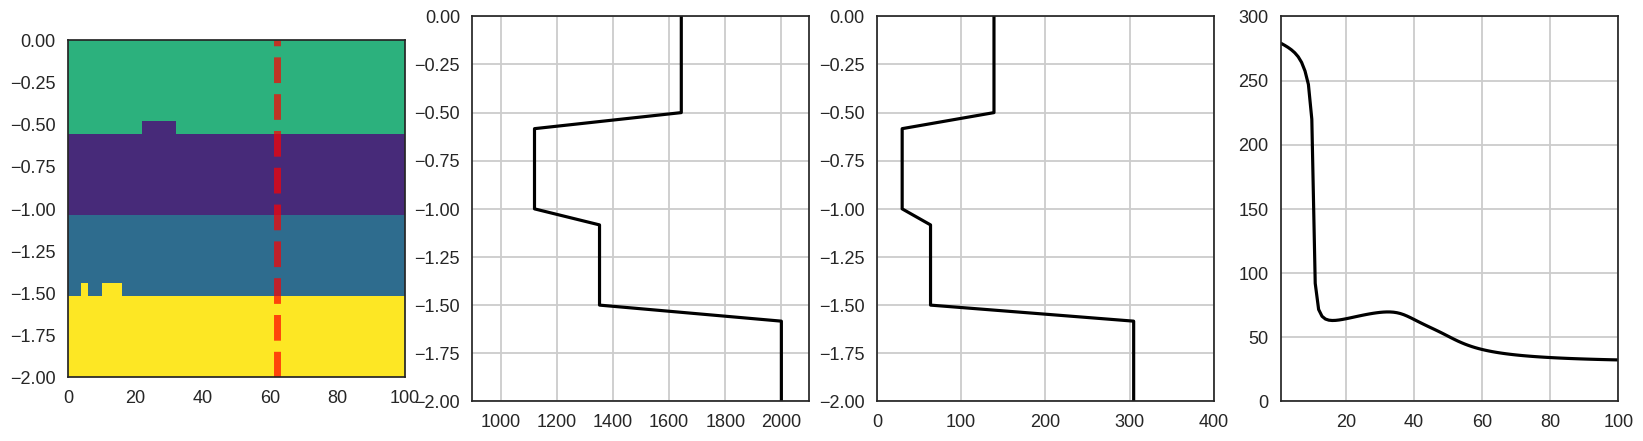

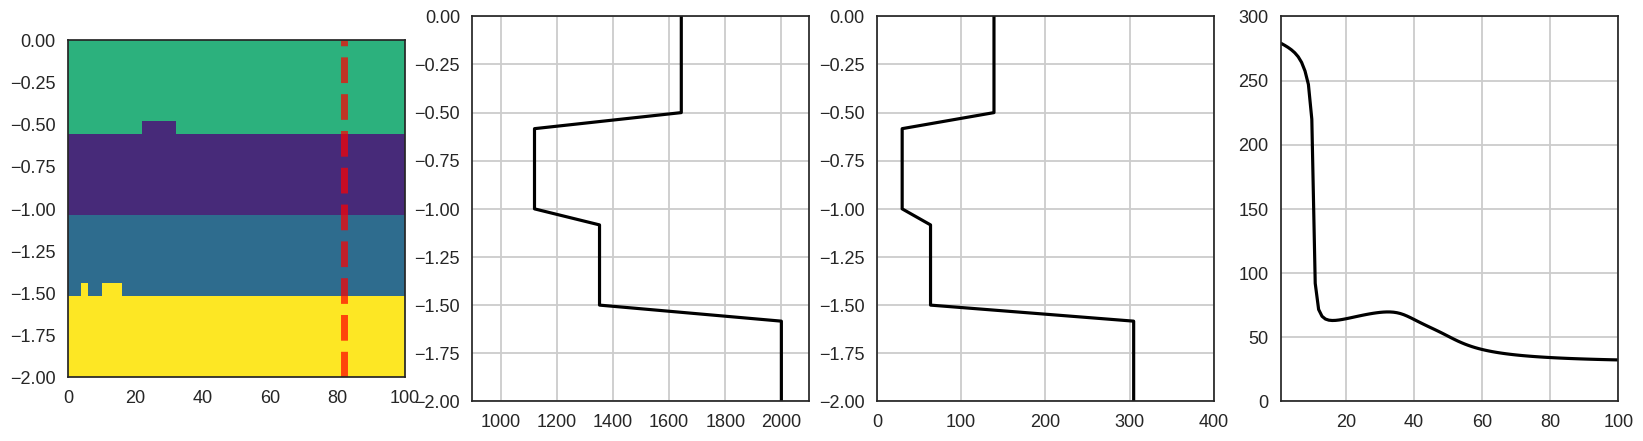

In [77]:
profile_lst = []
dispersion_curve_lst = []
hz_lst = [] 

profile_number = np.random.random(size=1)

for ix in lst_receptor:
    fig, (ax, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(20, 5))

    im = ax.imshow(slice_block, cmap='viridis',extent=[0, 100, -2.0, 0],vmin=1000.0,vmax=2000.0,aspect=50,origin='lower')
    ax.vlines(x=ix*(north/grid_reso),ymin=-2.0,ymax=0,colors='r',lw=5.0,ls='--',alpha=0.7)

    profile_lst.append(slice_block[:,ix])
    ax1.plot(slice_block[:,ix],np.linspace(-2., 0,len(slice_block[:,ix])),'-k')
    ax1.set_xlim(900.0,2100.0)
    ax1.set_ylim(-2.0,0.0)
    ax1.grid('on')
         
    velocity_model = create_velocity_model_from_profile(model_profile=slice_block[:,ix][::-1])

    velocity_p,velocity_s = calculate_parameters(slice_block[:,ix])

    ax2.plot(velocity_s,np.linspace(-2., 0,len(slice_block[:,ix])),'-k')
    ax2.set_ylim(-2.0,0.0)
    ax2.set_xlim(0,400)
    ax2.grid('on')    
    
    cpr = estimate_disp_from_velocity_model(velocity_model)  

    dispersion_curve_lst.append(cpr.velocity*1000)
    hz_lst.append(1/cpr.period)
    ax3.plot(1/cpr.period,cpr.velocity*1000,'-k')
    ax3.grid('on')
    ax3.set_ylim(0,300)
    ax3.set_xlim(1,100)


In [78]:
filename_npy = 'data/density_block.npy'

data_grid = np.load(filename_npy)

In [79]:
data_grid.shape

(50, 50, 25)

In [80]:
def create_layers(min_esp, max_esp,max_total=0.002):
    thick_lst = []
    total = 0.0

    while total < max_total:
        esp = random.uniform(min_esp, max_esp)
        thick_lst.append(round(esp, 4)) 
        total += esp
        if total >= max_total:
            break

    return thick_lst

In [81]:
def uniform(low_thick, up_thick,low_vels,up_vels):
    thickness_lst = create_layers(low_thick,up_thick)
    
    vs_lst = []
    for s in range(1,len(thickness_lst)+1):
        if s == 1:
            vs_lst.append(np.random.uniform(low_vels,up_vels))
        else:
            vs_lst.append(np.random.uniform(low_vels*(s),up_vels*(s)))
    return [thickness_lst,vs_lst]

# Função objetivo 

$misfit = \sqrt{\sum_{i=1}^{n^f}\frac{(x_{di}-x_{ci})^2}{\sigma_{i}^{2}n_{f}}}$

In [82]:
# Função objetivo para a inversão usando DEAP
def inversion_objective(individual, true_disp,number_samples=100):
    try:
        # Simula a curva de dispersão com base nas velocidades estimadas de Vs (indivíduo) para otimização
        simulated_velocity_model = create_velocity_model_from_profile_vs(individual)
            
        simulated_cpr = estimate_disp_from_velocity_model(simulated_velocity_model)
            
        simulated_dispersion = simulated_cpr.velocity*1000
                
        # Calcula o erro como a soma dos quadrados das diferenças entre a curva simulada e a curva estimada
    
        # In the above equation, xdi represents the Rayleigh wave phase velocity of the experimental 
        # dispersion data at frequency fi ; xci is the theoretical Rayleigh wave phase velocity computed
        # for the trial layered earth model at frequency fi ; σi is the standard deviation associated 
        # with the experimental dispersion data at frequency fi ; and nf is the number of frequency samples 
        # considered for the misfit calculation.
        
        nf = number_samples 
        sigma = np.std(true_disp)
    
        misfit = np.sqrt(np.sum(((true_disp - simulated_dispersion) ** 2) / (sigma ** 2)) / nf)

        #misfit = np.sum((true_disp - simulated_dispersion) ** 2)

    
    except:
        misfit = 10

    objective_values.append(misfit)
        
    return misfit,

In [83]:
def crossover_two_point(ind1, ind2, cxpb=0.5):
    """
    Aplica Two-Point Crossover nos indivíduos, garantindo que os tamanhos internos
    das sublistas permaneçam inalterados e respeitando o menor comprimento entre indivíduos.
    
    Args:
        ind1 (list): Primeiro indivíduo composto por duas sublistas.
        ind2 (list): Segundo indivíduo composto por duas sublistas.
        cxpb (float): Probabilidade de realizar crossover.
        
    Returns:
        tuple: Os dois indivíduos após o crossover.
    """
    for i in range(len(ind1)):  # Itera sobre as sublistas (espessura e velocidade)
        if random.random() < cxpb:  # Decide se fará crossover nessa sublista
            # Determina o menor comprimento entre as sublistas equivalentes
            size = min(len(ind1[i]), len(ind2[i]))
            if size > 1:  # Apenas realiza crossover se houver ao menos dois elementos
                # Seleciona dois pontos de crossover
                point1, point2 = sorted(random.sample(range(size), 2))
                
                # Troca os valores entre os dois pontos
                for j in range(point1, point2 + 1):
                    ind1[i][j], ind2[i][j] = ind2[i][j], ind1[i][j]
    return ind1, ind2

In [84]:
def mutate_swap(ind,mutpb=0.1):
    """
    Aplica mutação de troca nos valores internos de um indivíduo (espessura e velocidade),
    garantindo que o tamanho interno de cada sublista permaneça inalterado.
    
    Args:
        ind (list): Indivíduo composto por duas sublistas.
        
    Returns:
        tuple: O indivíduo após a mutação.
    """
    for i in range(len(ind)):  # Itera sobre as sublistas (espessura e velocidade)
        if random.random() < mutpb:  # Probabilidade de mutação
            # Seleciona dois índices aleatórios distintos
            idx1, idx2 = random.sample(range(len(ind[i])), 2)
            # Realiza a troca dos valores
            ind[i][idx1], ind[i][idx2] = ind[i][idx2], ind[i][idx1]
    return ind,

In [85]:
def statistics_save(individual):
    return individual.fitness.values

In [86]:
# Variáveis globais para armazenar os valores da função objetivo por iteração
objective_values = []

# Configuração da DEAP para otimização evolutiva
def configure_deap(estimated_disp):

    # deap.creator: meta-factory allowing to create classes that will fulfill the needs of your evolutionary algorithms.
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    # deap.base.Toolbox: A toolbox for evolution that contains the evolutionary operators. You may populate the toolbox with any other function by using the register() method
    toolbox = base.Toolbox()

    # Attribute generator
    toolbox.register("model", uniform, 0.0002,0.0005,20,100)  # Intervalo de velocidades S (Vs)

    # Structure initializers
    toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.model)
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    toolbox.register("evaluate", inversion_objective, true_disp=estimated_disp)

    # The general rule for crossover operators is that they only mate individuals, 
    # this means that an independent copies must be made prior to mating the individuals 
    # if the original individuals have to be kept or is are references to other individuals (see the selection operator).
    # --> Each crossover has its own characteristics and may be applied to different type of individuals.
    # Lets apply a crossover operation:
    toolbox.register("mate", crossover_two_point)

    # The general rule for mutation operators is that they only mutate, 
    # this means that an independent copy must be made prior to mutating 
    # the individual if the original individual has to be kept or is a 
    # reference to an other individual (see the selection operator).
    # --> Each mutation has its own characteristics and may be applied to different type of individual.
    # In order to apply a mutation (here a gaussian mutation) on the individual ind1, simply apply the desired function.
    toolbox.register("mutate", mutate_swap)
    
    # Selection is made among a population by the selection operators that are available in the deap.operators module.
    # The selection operator usually takes as first argument an iterable container of individuals and the number of individuals to select. 
    # It returns a list containing the references to the selected individuals.
    toolbox.register("select", tools.selTournament, tournsize=3)
    
    return toolbox

In [87]:
# Carregar as velocidades estimadas 
estimated_disp = dispersion_curve_lst[0]

# Configurar DEAP
toolbox = configure_deap(estimated_disp)

/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/sysop/Programs/anaconda3/lib/python3.12/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [88]:
# Realizar a evolução (inversão) usando algoritmo genético
population = toolbox.population(n=5000)

estatistica = tools.Statistics(statistics_save)
estatistica.register('mean',np.mean)
estatistica.register('min',np.mean)
estatistica.register('max',np.mean)

hof = tools.HallOfFame(1)

result, log = algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=50,stats=estatistica,halloffame=hof,verbose=True)

gen	nevals	mean   	min    	max    
0  	5000  	1.72608	1.72608	1.72608
1  	2920  	1.06831	1.06831	1.06831
2  	3019  	0.75091	0.75091	0.75091
3  	2955  	0.61588	0.61588	0.61588
4  	2992  	0.540878	0.540878	0.540878
5  	2991  	0.477808	0.477808	0.477808
6  	2964  	0.433419	0.433419	0.433419
7  	2990  	0.387458	0.387458	0.387458
8  	2909  	0.352885	0.352885	0.352885
9  	3050  	0.35896 	0.35896 	0.35896 
10 	2952  	0.342611	0.342611	0.342611
11 	2957  	0.31064 	0.31064 	0.31064 
12 	2934  	0.268162	0.268162	0.268162
13 	3016  	0.243664	0.243664	0.243664
14 	2921  	0.175646	0.175646	0.175646
15 	3008  	0.181989	0.181989	0.181989
16 	3018  	0.194682	0.194682	0.194682
17 	2998  	0.157683	0.157683	0.157683
18 	3090  	0.128457	0.128457	0.128457
19 	2981  	0.100156	0.100156	0.100156
20 	2989  	0.0886501	0.0886501	0.0886501
21 	3003  	0.0780678	0.0780678	0.0780678
22 	2998  	0.057178 	0.057178 	0.057178 
23 	2988  	0.062285 	0.062285 	0.062285 
24 	2952  	0.0584192	0.0584192	0.0584192
25 	2976  	0

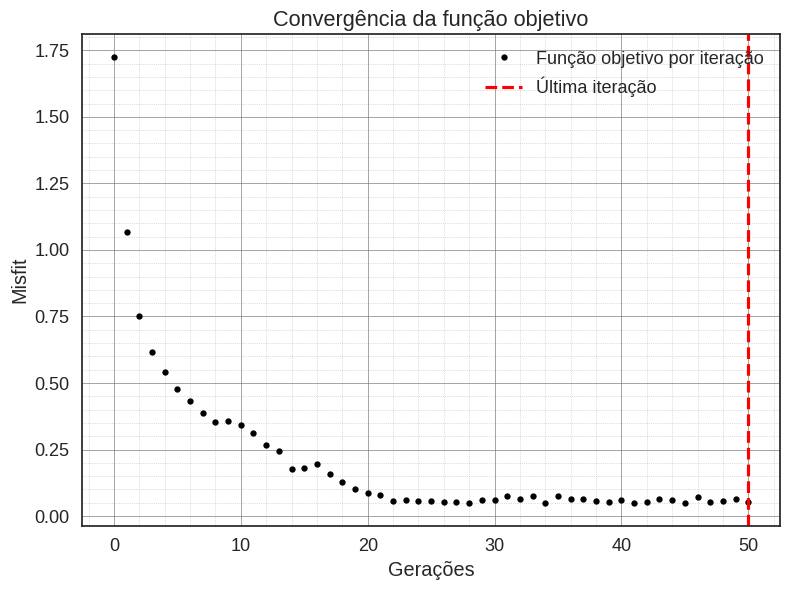

In [89]:
fig, ax = plt.subplots(figsize=(8, 6))
add_label = True  # Variável de controle para adicionar o label apenas uma vez
for keys in log:
    if add_label:
        ax.plot(keys['gen'],keys['mean'],'.k', label='Função objetivo por iteração')
        add_label = False
    else:
        ax.plot(keys['gen'], keys['mean'], '.k')  # Sem o label

ax.set_title('Convergência da função objetivo')
ax.set_xlabel('Gerações')
ax.set_ylabel('Misfit')
ax.axvline(x=len(log)-1, color='red', linestyle='--', label='Última iteração')
ax.legend(loc='upper right')
ax.grid(True)
plt.tight_layout()
ax.minorticks_on()
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)

plt.savefig('convergencia_funcao_objetivo.png', dpi=300)


(0.0, 400.0)

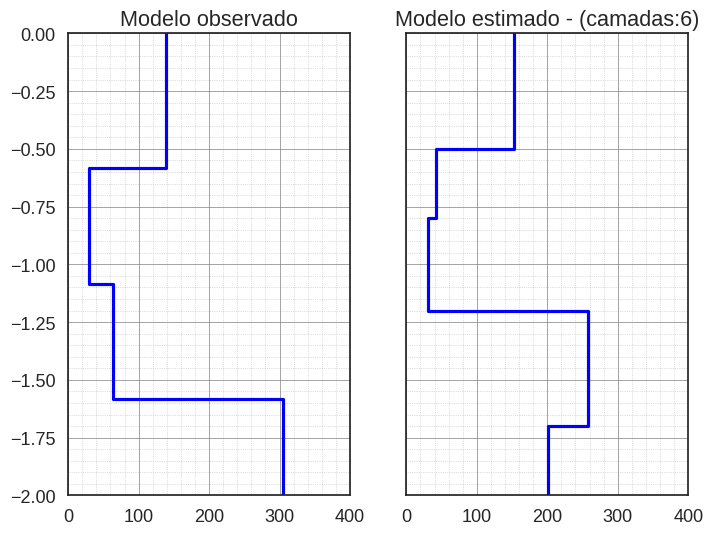

In [90]:
fig, (ax,ax1) = plt.subplots(1,2,figsize=(8, 6),sharey=True)
ax.set_title('Modelo observado')
ax.step(velocity_s,np.linspace(-2., 0,len(slice_block[:,ix])),'-b', where='post')
ax.minorticks_on()
ax.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax.set_ylim(-2,0)
ax.set_xlim(0,400)


velocities = hof[-1][1]
depths = np.cumsum([i*-1000 for i in result[-1][0]]).tolist()
velocities.insert(0,velocities[0])
depths.insert(0,0)

ax1.set_title('Modelo estimado - (camadas:'+str(len(result[-1][0]))+')')
ax1.step(velocities,depths,'-b', where='post')
ax1.minorticks_on()
ax1.grid(which='major', color='gray', linestyle='-', linewidth=0.5)
ax1.grid(which='minor', color='gray', linestyle=':', linewidth=0.5, alpha=0.5)
ax1.set_ylim(-2,0)
ax1.set_xlim(0,400)

# Calcular percentual de variação entre as camadas 
# Plotar ajustes 

In [ ]:
hof[0]